## Stock predictions
using Linear Regression,Quadratic regression and KNN

### Data wrangling

In [1]:
import pandas as pd
import datetime
from pandas import Series, DataFrame
#had to ditch the online web reader initially due to environment

amzn = r"AMZN.csv"
goog = r"GOOG.csv"
tsla = r"TSLA.csv"

df = pd.read_csv(amzn) 

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)
df.tail()

Date         Open         High          Low        Close  \
2007  2019-08-30  1797.489990  1799.739990  1764.569946  1776.290039   
2008  2019-09-03  1770.000000  1800.800049  1768.000000  1789.839966   
2009  2019-09-04  1805.000000  1807.630005  1796.229980  1800.619995   
2010  2019-09-05  1821.949951  1842.000000  1815.579956  1840.719971   
2011  2019-09-06  1838.219971  1840.650024  1826.400024  1833.510010   

        Adj Close   Volume  
2007  1776.290039  3058700  
2008  1789.839966  3543000  
2009  1800.619995  2324100  
2010  1840.719971  3310800  
2011  1833.510010  2489700

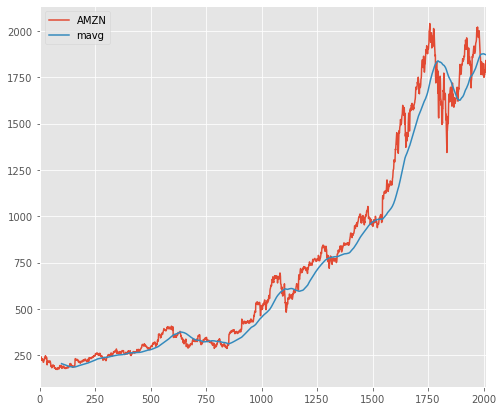

In [2]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AMZN')
mavg.plot(label='mavg')
plt.legend()

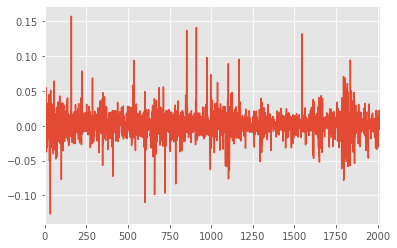

In [3]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [4]:
# reformat dataframes to match guide
files = [amzn,goog,tsla]
li = []
# maybe next time set the keys to be dates df.set_index(keys='Date')
for filename in files:
    df_x = pd.read_csv(filename,index_col=None,header=0)
    li.append(df_x)

dfamzn = li[0]
dfgoog = li[1]
dftsla = li[2]

In [5]:
droplist = ['Open','High','Low','Close','Volume']
dfamzn.drop(columns = droplist,inplace = True)
dfgoog.drop(columns = droplist,inplace = True)
dftsla.drop(columns = droplist,inplace = True)

adjList = [dfamzn,dfgoog,dftsla]

dfcomp = pd.concat(adjList, axis=1,ignore_index=True)
dfcomp.rename(columns={0:'Date',1:'AMZN',2:'Date1',3:'GOOG',4:'Date2',5:'TSLA'},inplace=True)
dfcomp.drop(columns = ['Date1','Date2'],inplace=True)
dfcomp.set_index(keys='Date',inplace=True)


dfcomp.head()

AMZN        GOOG       TSLA
Date                                         
2011-09-08  217.259995  266.481171  23.610001
2011-09-09  211.389999  261.445038  22.969999
2011-09-12  216.559998  264.070190  22.879999
2011-09-13  219.529999  263.771332  24.080000
2011-09-14  222.570007  265.041565  24.340000

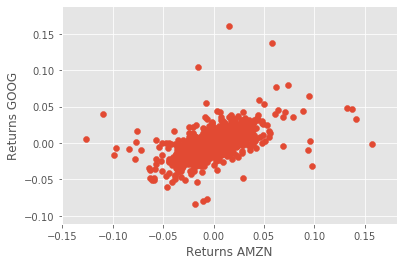

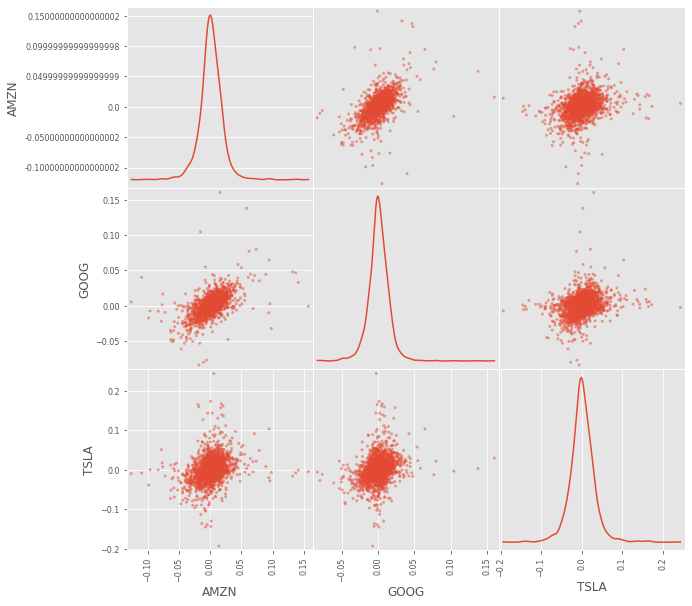

In [6]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

plt.scatter(retscomp.AMZN, retscomp.GOOG)
plt.xlabel('Returns AMZN')
plt.ylabel('Returns GOOG')

pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

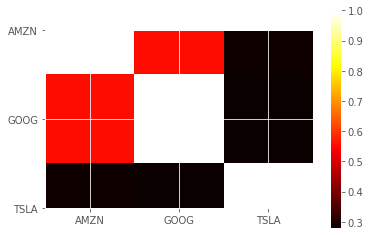

In [7]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

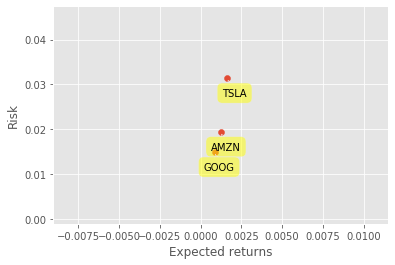

In [8]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    

## SciKit time!

In [9]:
import pandas as pd
import datetime
import numpy as np 
import pandas_datareader.data as web # finally got it working
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix 
from math import ceil 

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib import style
import matplotlib as mpl

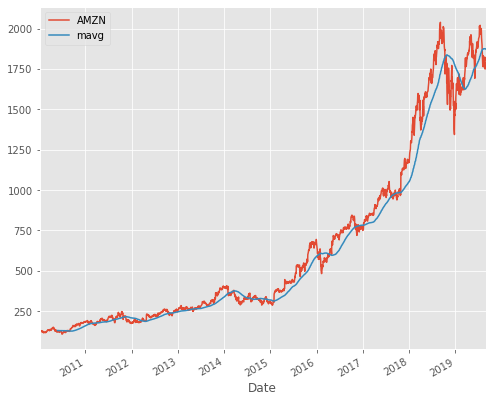

In [10]:
#Loading Yahoo Finance dataset
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2019, 9, 1)

df = web.DataReader("AMZN", "yahoo", start, end)
df.tail()

#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

#to better understand rolling mean, let's plot it on matplotlib

mpl.rc('figure', figsize=(8, 7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AMZN')
mavg.plot(label='mavg')
plt.legend()

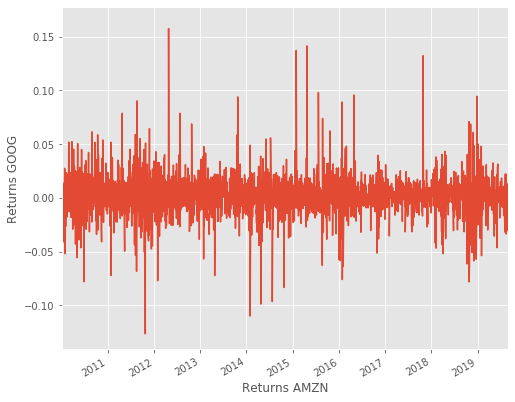

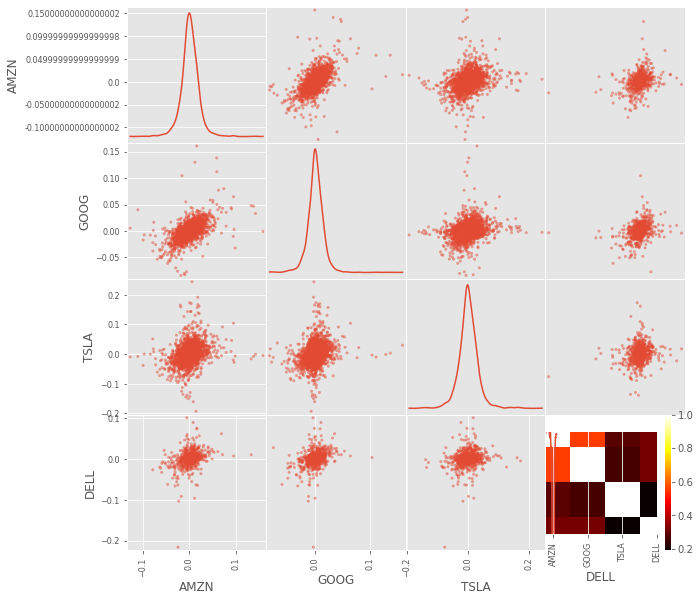

In [11]:
#plot the returns of the stock
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

#analyzing competitor stocks as well
dfcomp = web.DataReader(['AMZN', 'GOOG', 'TSLA', 'DELL'], 'yahoo', start=start, end=end)['Adj Close']

# run a correlation function to see if any of the stocks are correlated
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

#plotting competitors to see their return distributions
plt.scatter(retscomp.AMZN, retscomp.GOOG)
plt.xlabel('Returns AMZN')
plt.ylabel('Returns GOOG')

#using Kernel Density Estimate to smooth data and visualize possible correlations
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

#create a heatmap to prove the positive correlations
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);



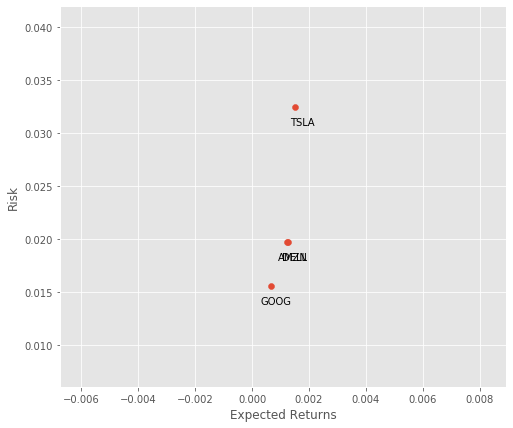

In [12]:
#extracting the average of returns and standard deviation of risk for each stock
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected Returns')
plt.ylabel('Risk')
for label, x, y, in zip(retscomp.columns, retscomp.mean(),
retscomp.std()): 
    plt.annotate(
        label, #this is the text
        xy = (x, y), #this is the point to label
        textcoords='offset points',#how to position the text. 
        xytext = (20, -20), #used to say test, changed to text. distance from text to points x,y
        ha='right', #horizontal alignment can be left right or center
        va='bottom') #vertical alignment can be top middle or bottom

In [13]:
#Engineering some features for the algorithms: High Low Percentage and Percentage Change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

##PREPROCESSING AND DATA VALIDATION
#Drop missing value
dfreg.fillna(value=-99999, inplace = True)
dfreg.dropna(inplace=True) #CORRECTION: ADDED NEW SO X AND y ARE EQUAL

#we want to separate 1% of the data to forecast
forecast_out = int(ceil(.01 * len(dfreg)))


In [14]:
#separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [15]:
#Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

#Finally we want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

#Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

##TIME TO START THE CLASSIFIERS!

#CORRECTION: DEFINING X_train before we use it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

#Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#KNN regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

#let's evaluate all of the models against eachother
confidencereg = clfreg.score(X_test,y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results
print('The linear regression confidence is', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately) 
forecast_set_poly2 = clfpoly2.predict(X_lately) 
forecast_set_poly3 = clfpoly3.predict(X_lately) 
forecast_set_knn = clfknn.predict(X_lately) 
dfreg['Forecast'] = np.nan

The linear regression confidence is 0.9819601666421774
The quadratic regression 2 confidence is  0.983658620974888
The quadratic regression 3 confidence is  0.9867945250962705
The knn regression confidence is  0.9710669599873284


### Linear Rregression plots

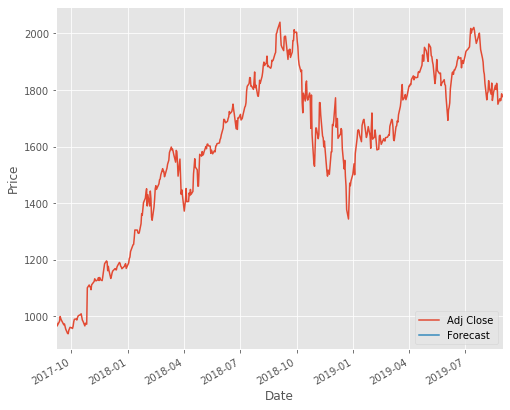

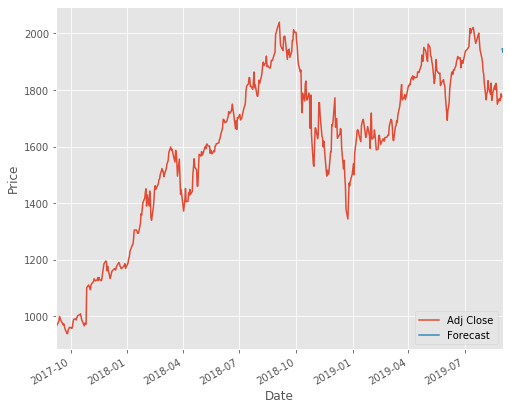

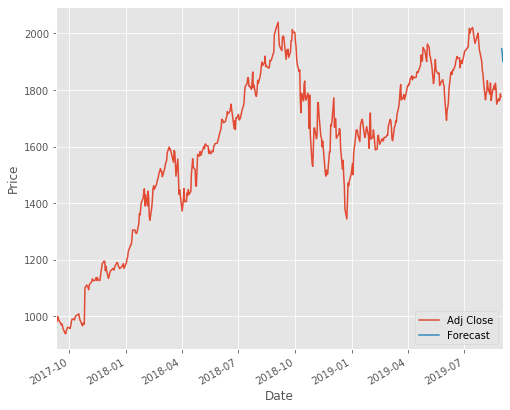

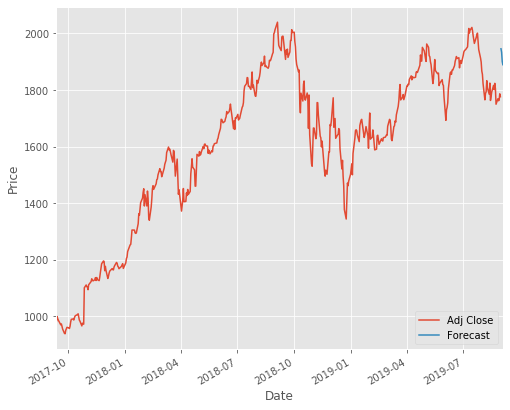

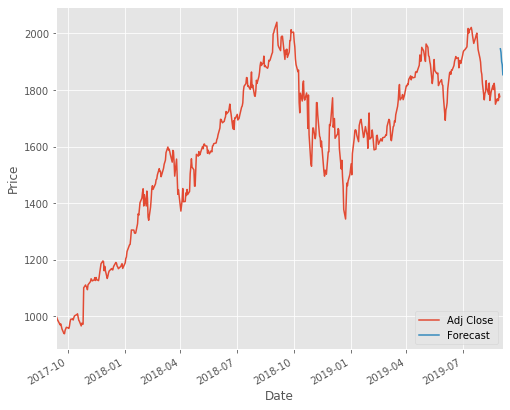

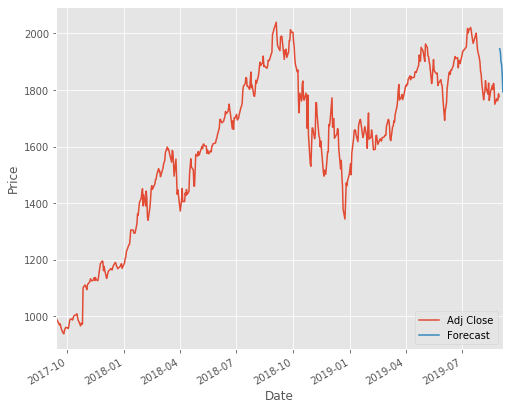

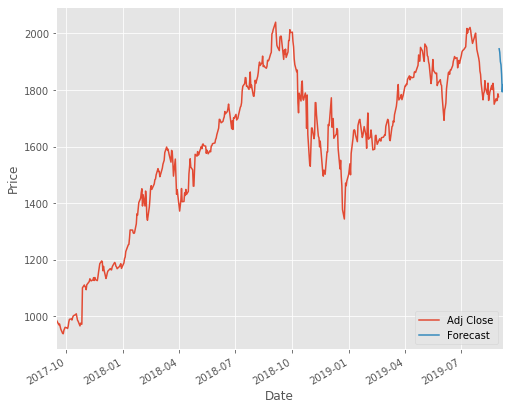

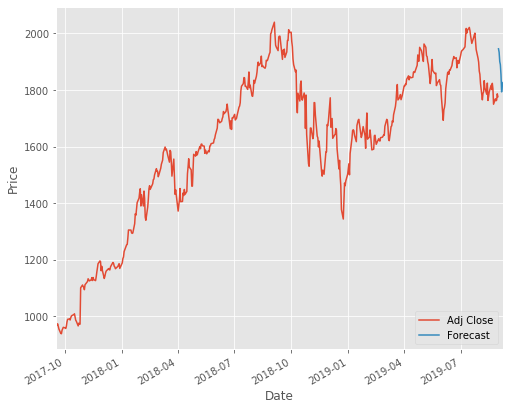

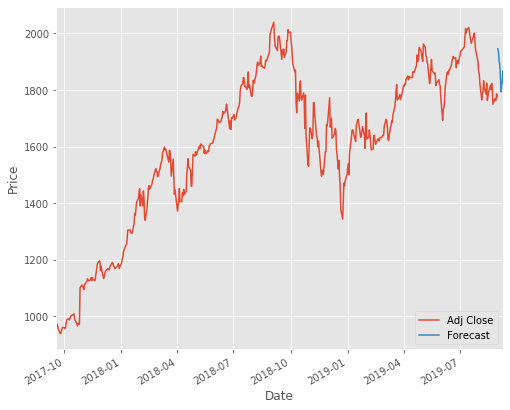

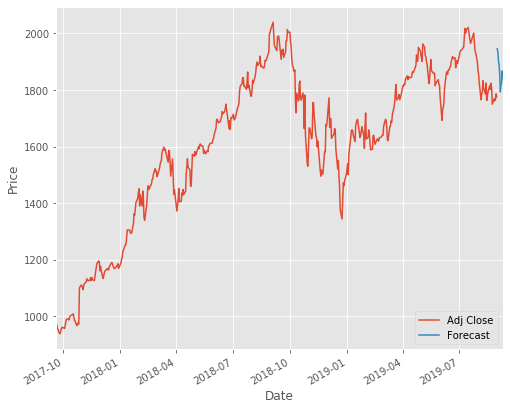

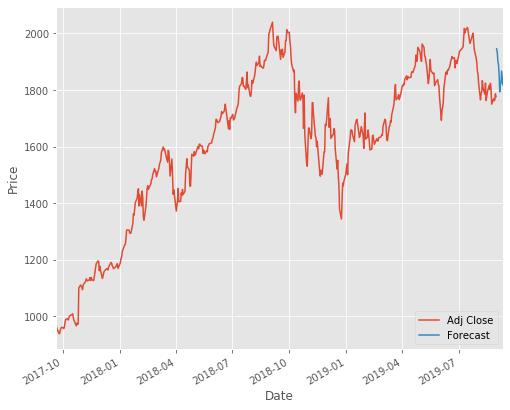

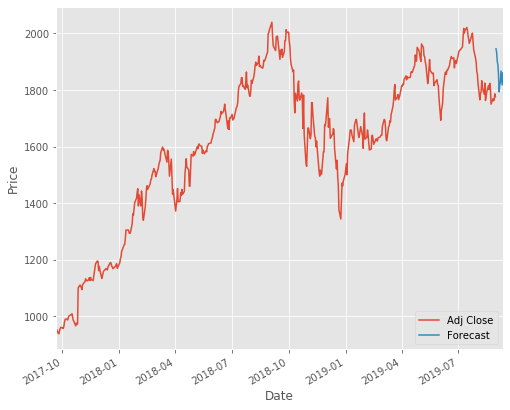

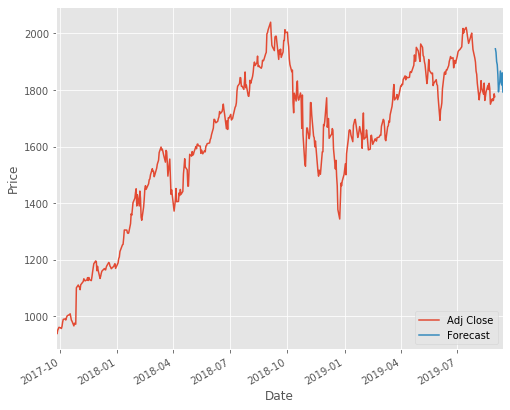

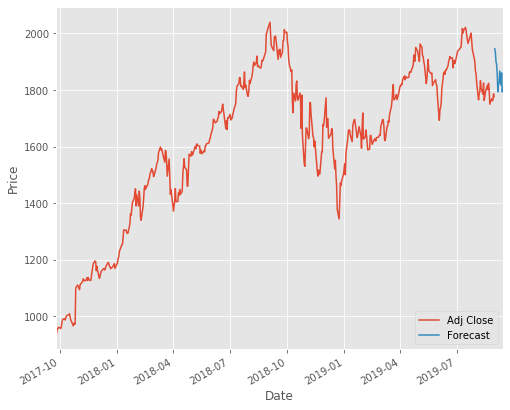

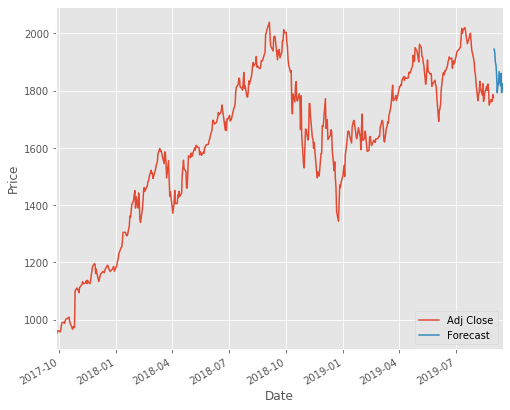

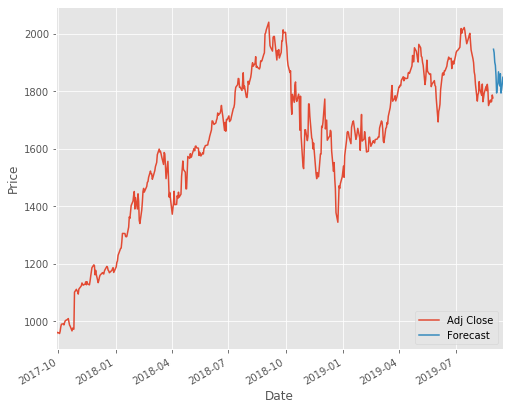

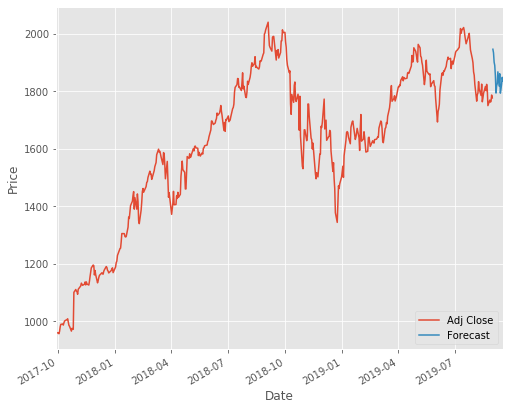

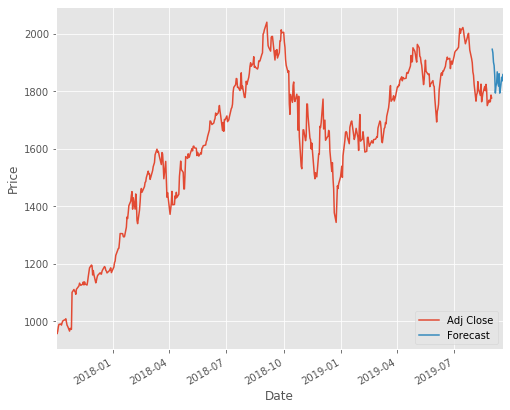

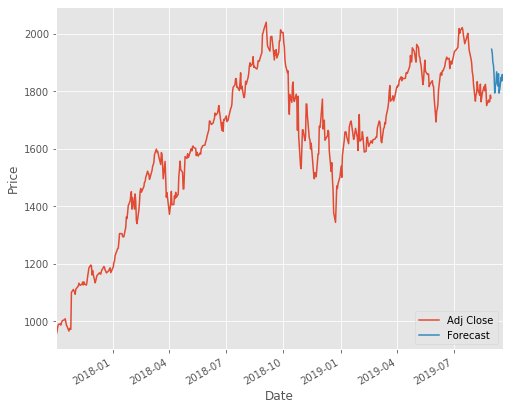

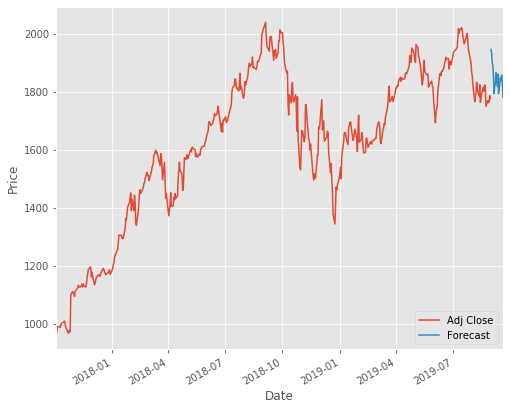

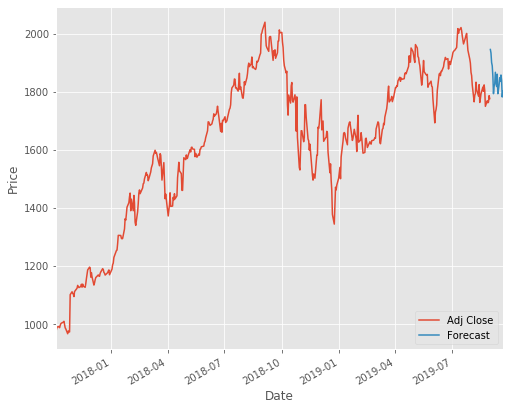

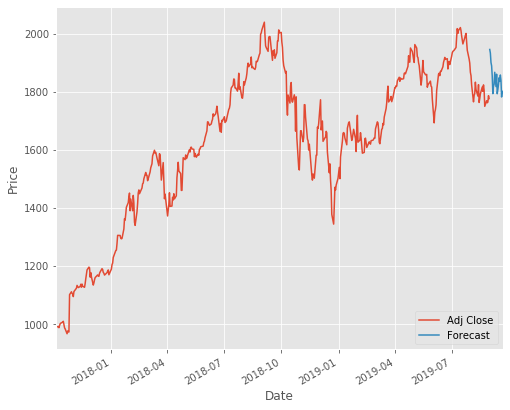

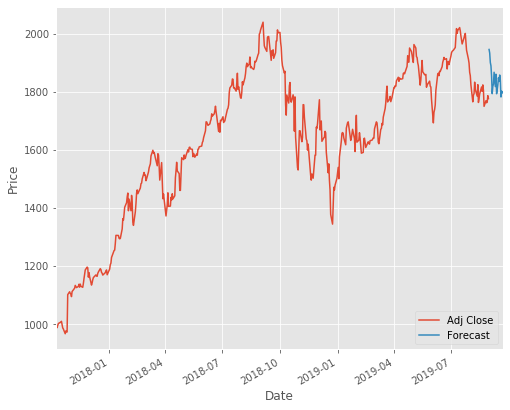

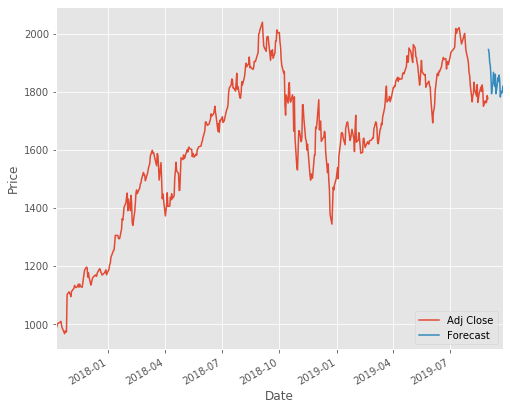

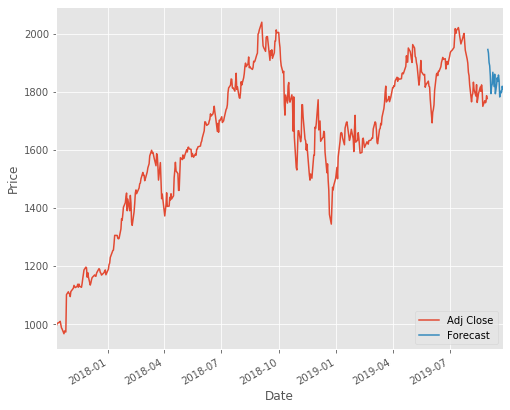

In [17]:
# linear regression plots

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg: 
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

### Quadratic Regression 2 plots

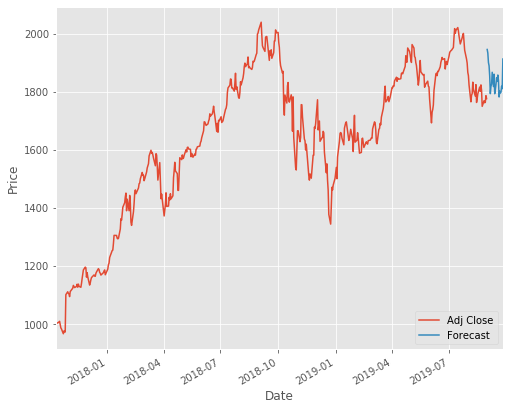

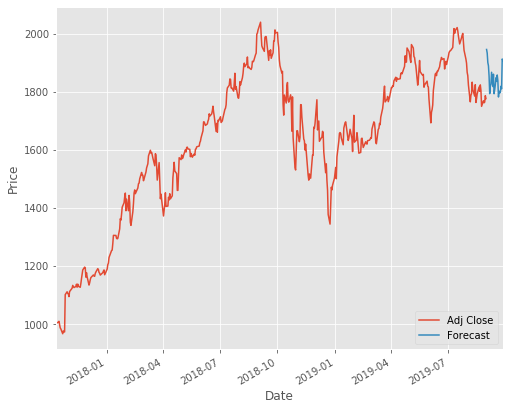

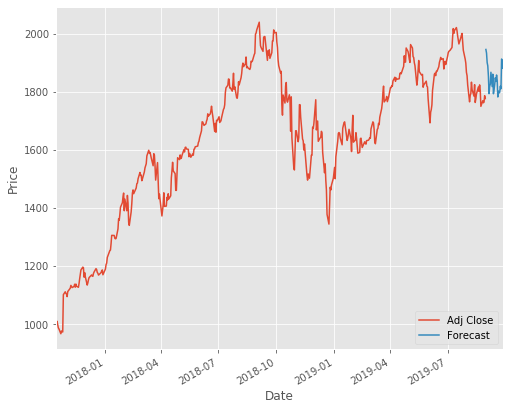

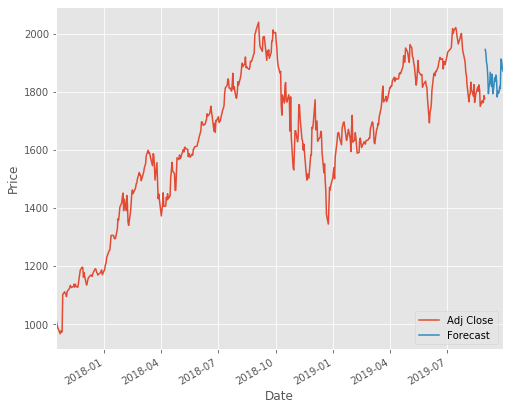

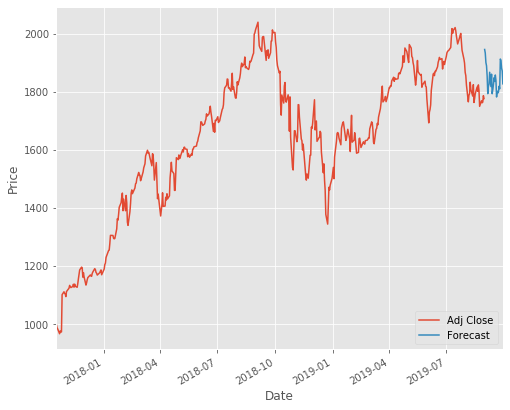

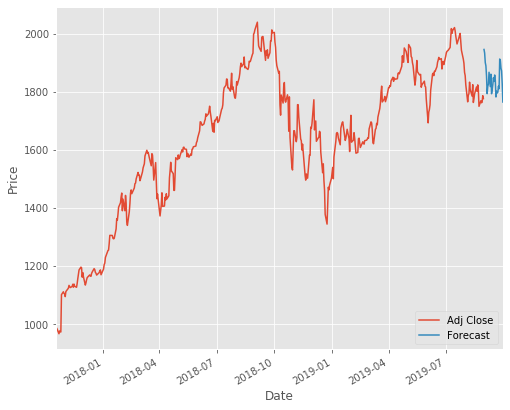

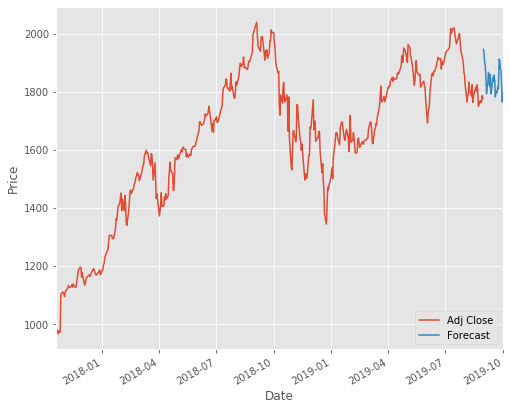

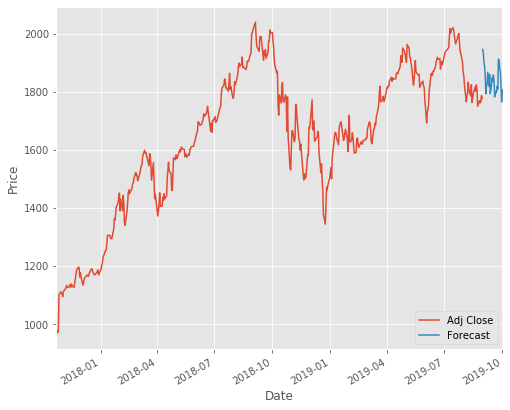

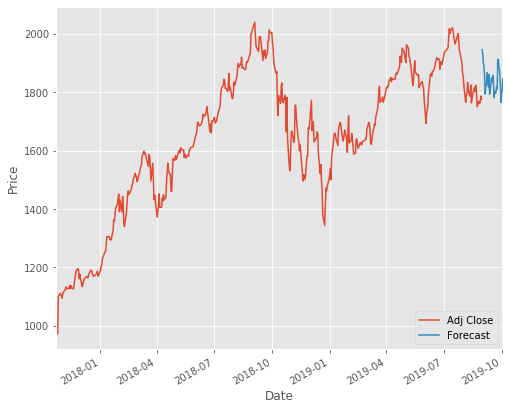

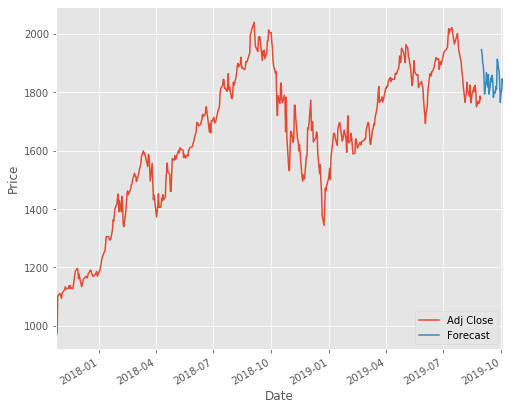

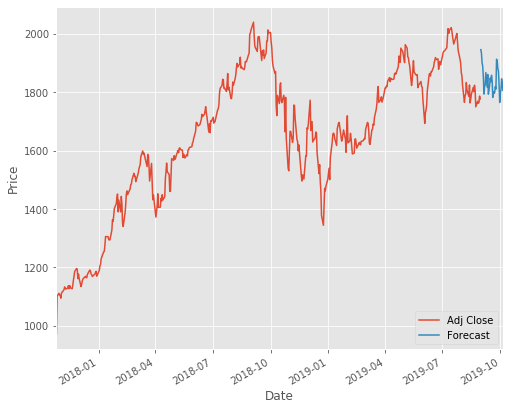

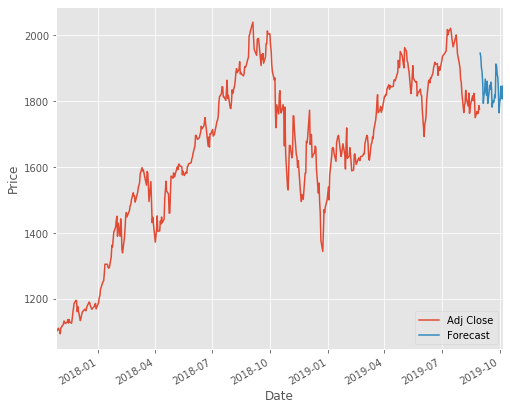

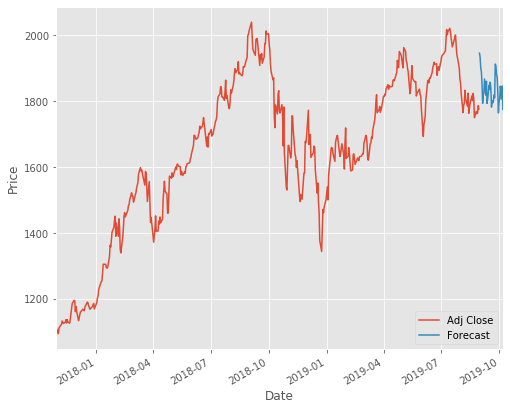

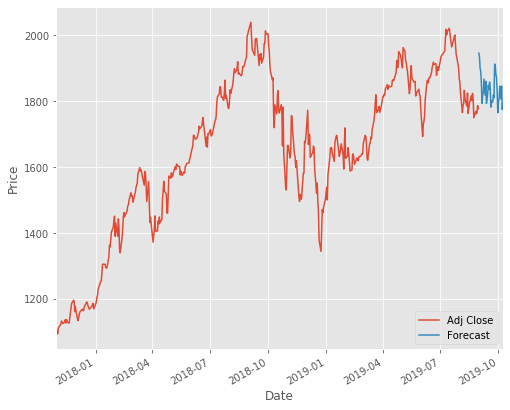

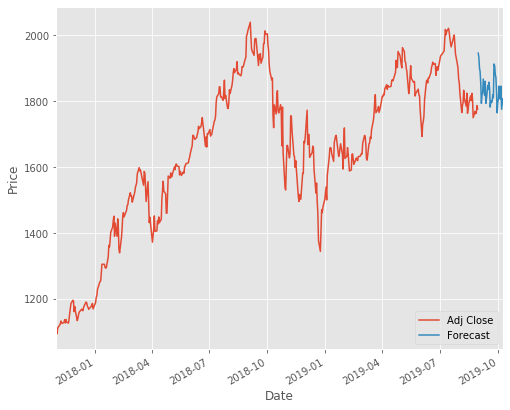

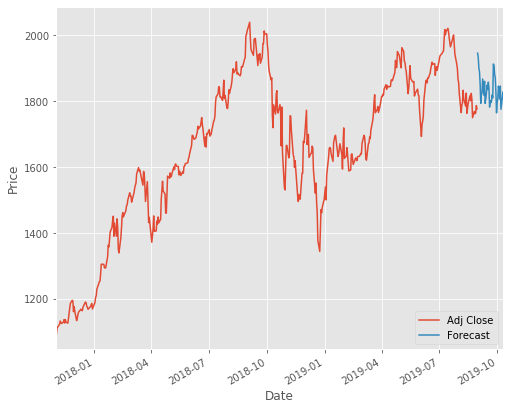

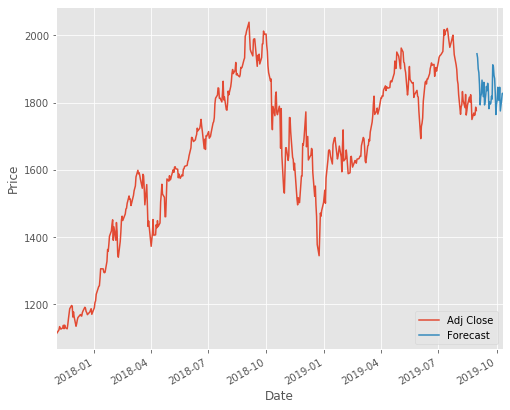

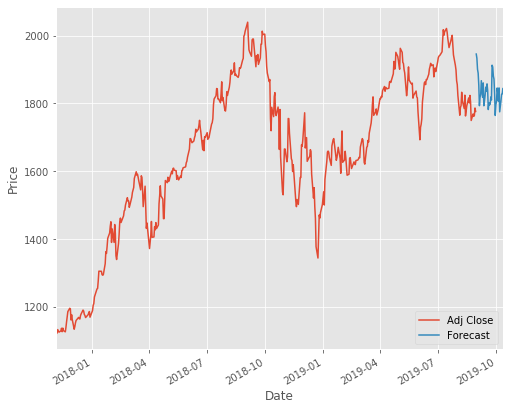

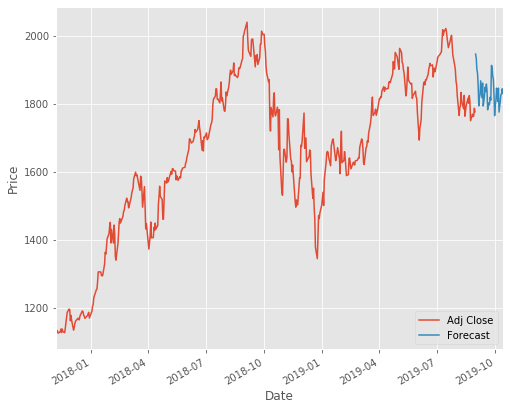

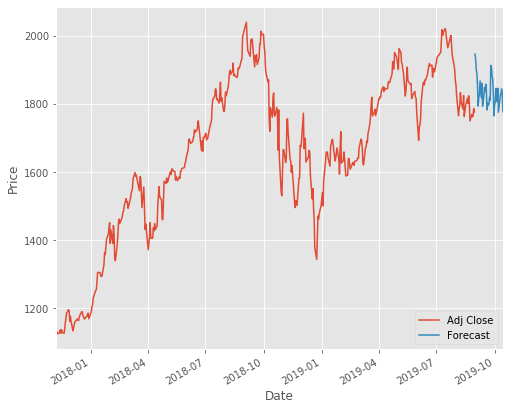

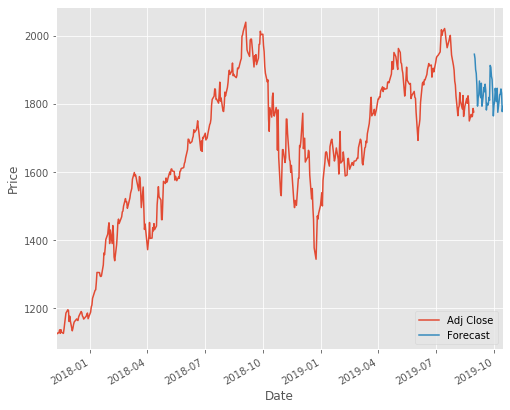

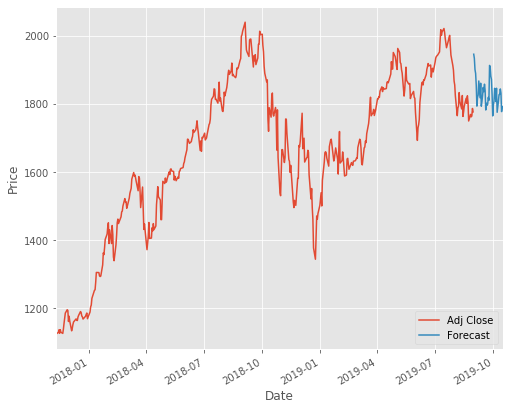

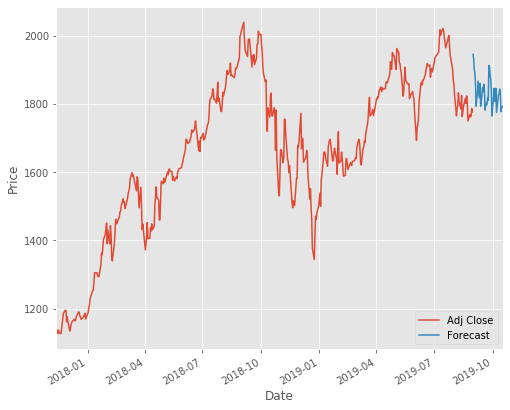

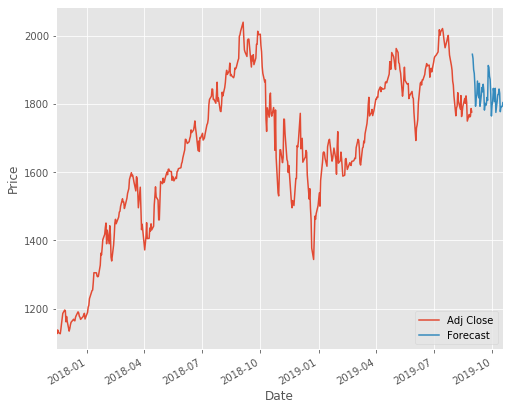

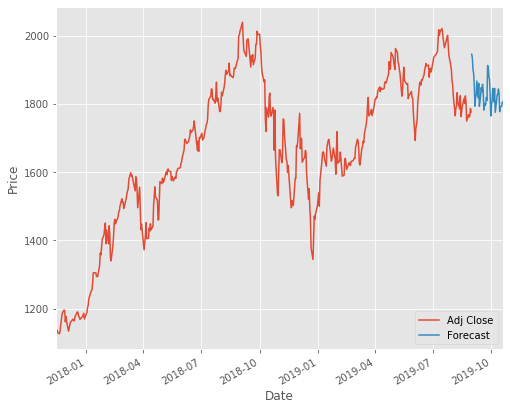

In [18]:

for i in forecast_set_poly2:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

### Quadratic Regression 3 plots

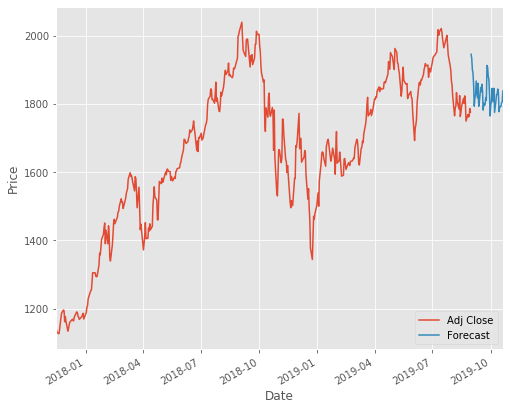

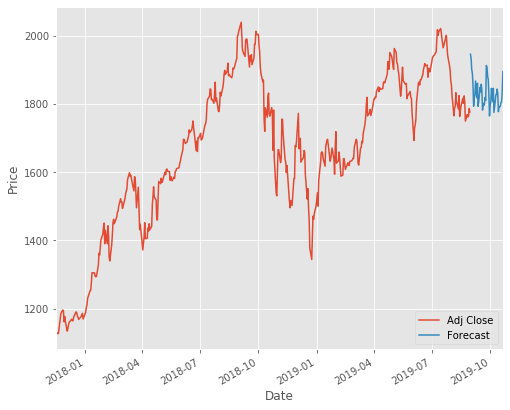

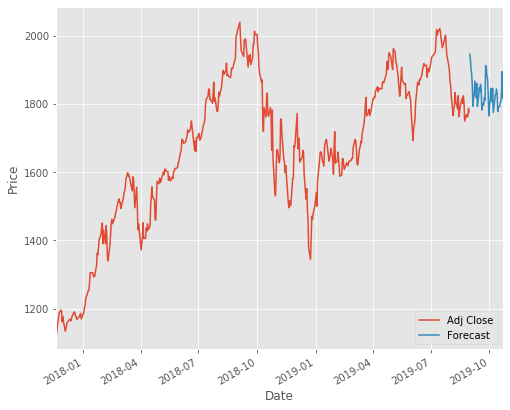

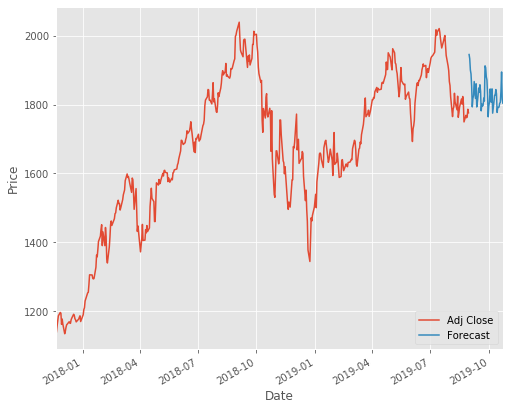

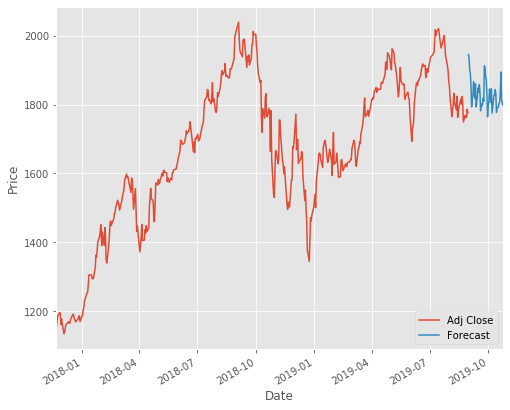

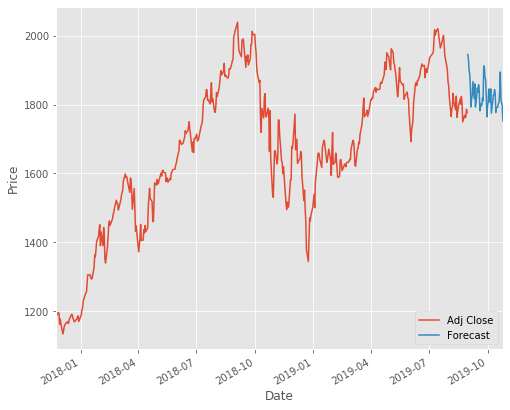

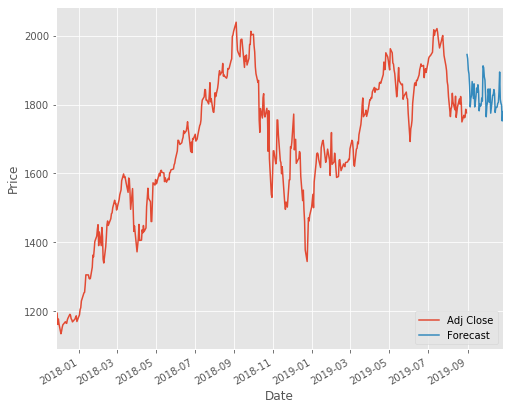

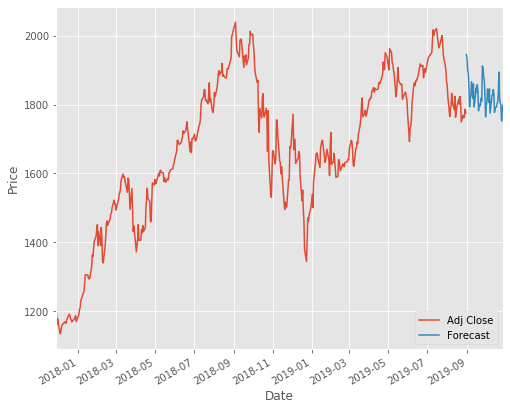

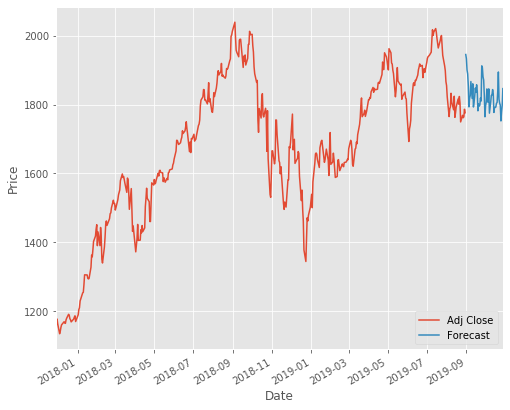

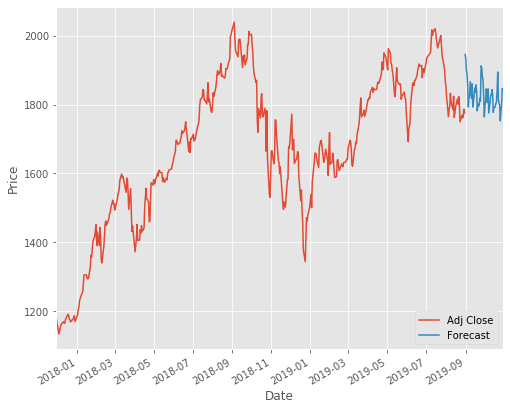

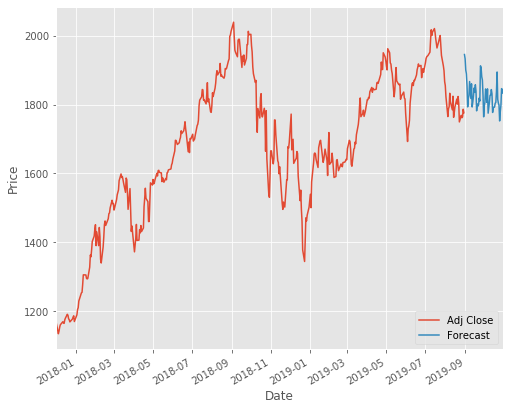

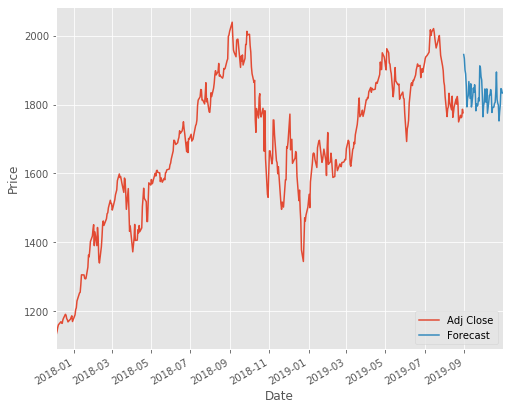

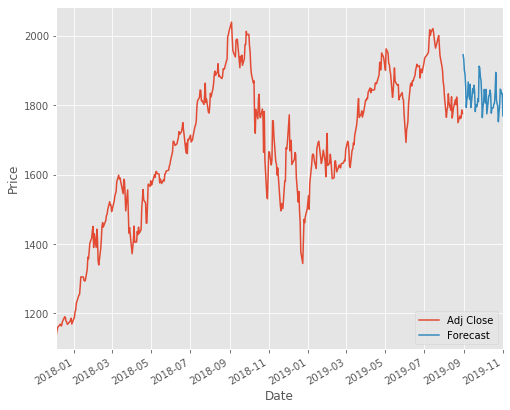

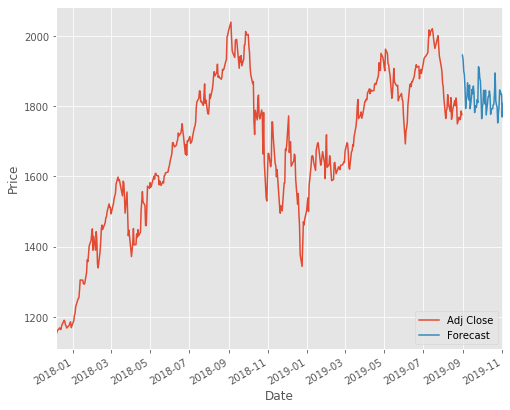

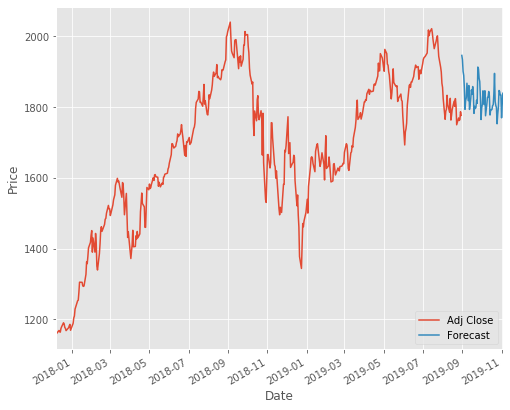

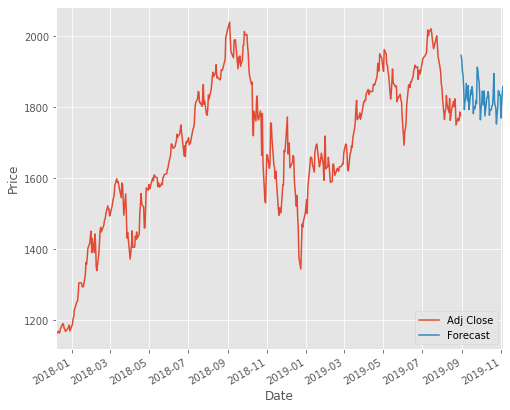

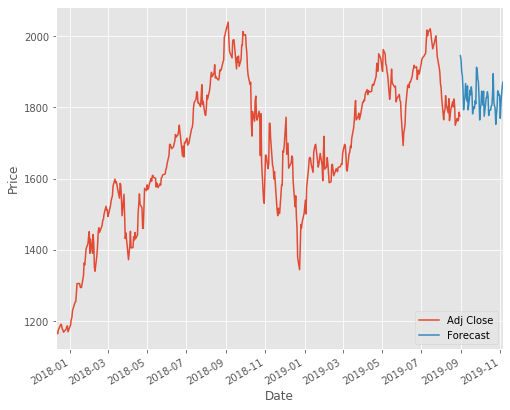

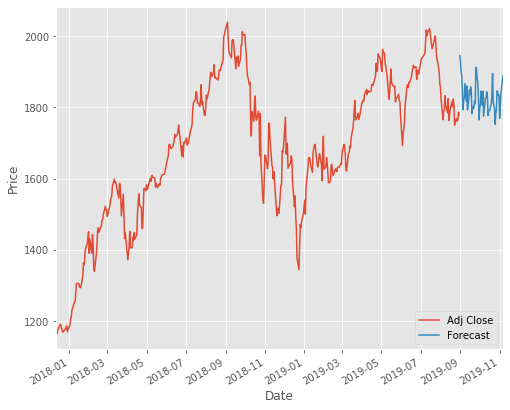

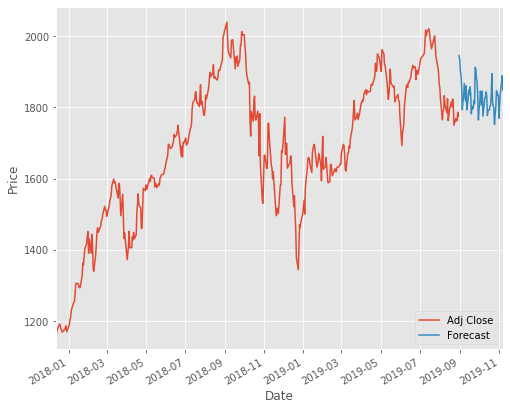

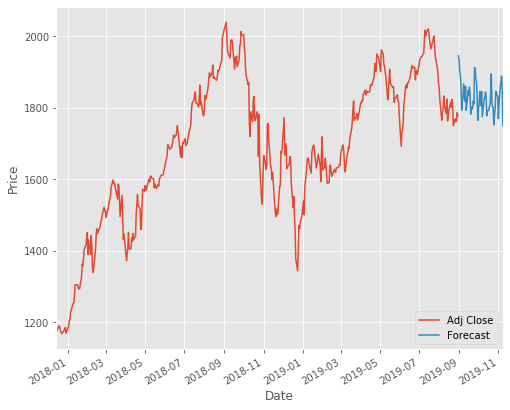

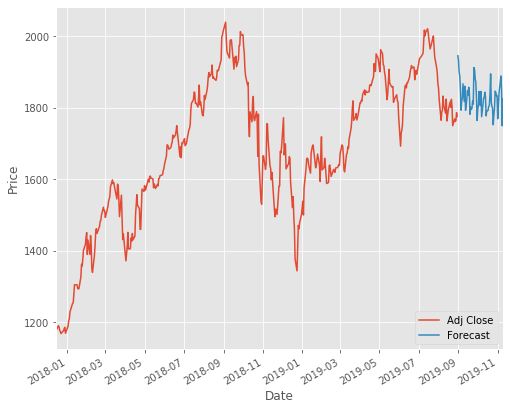

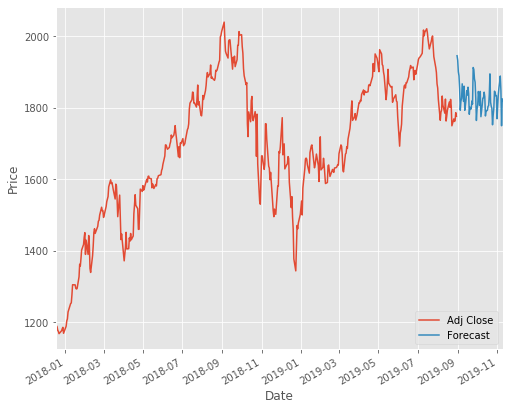

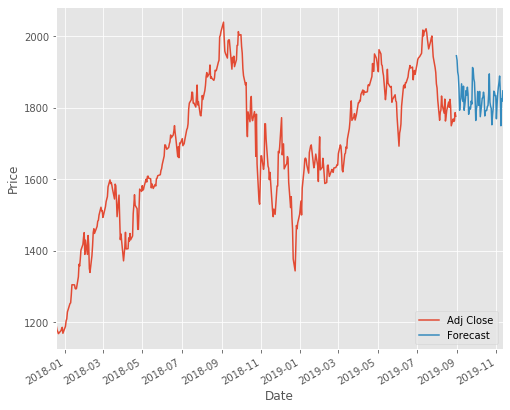

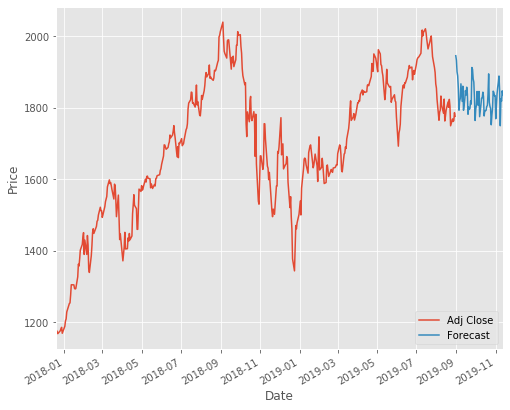

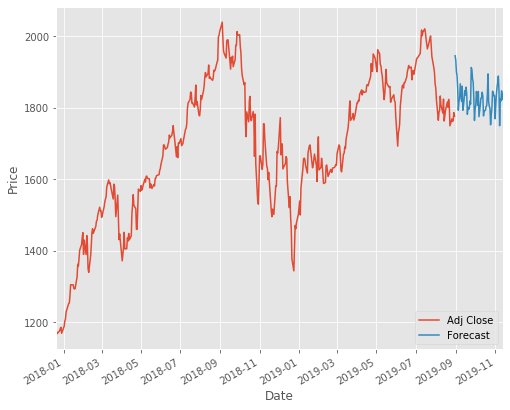

In [19]:
for i in forecast_set_poly3: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

### KNN plots

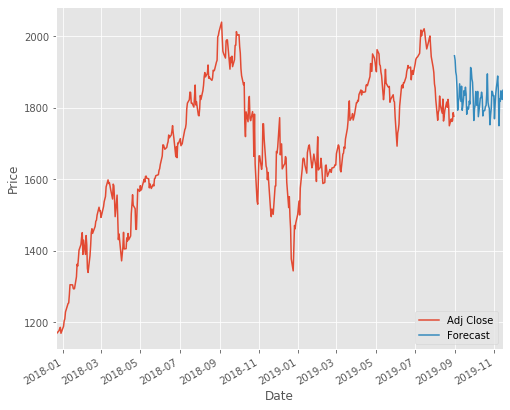

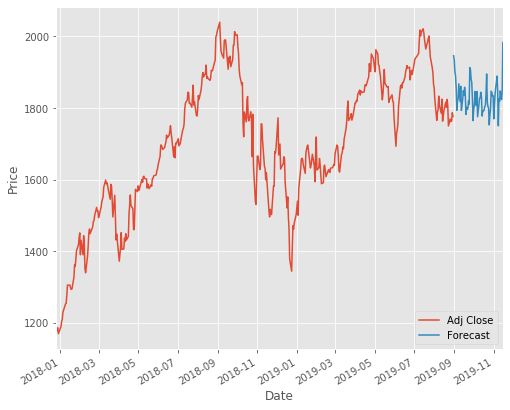

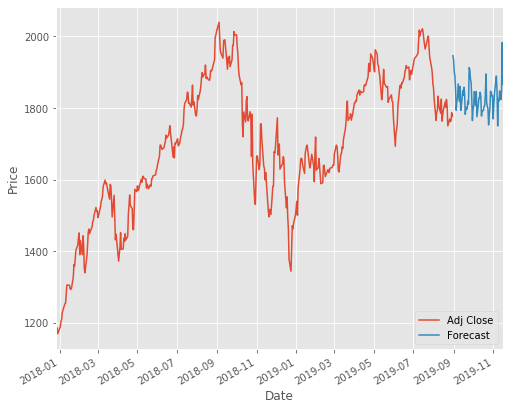

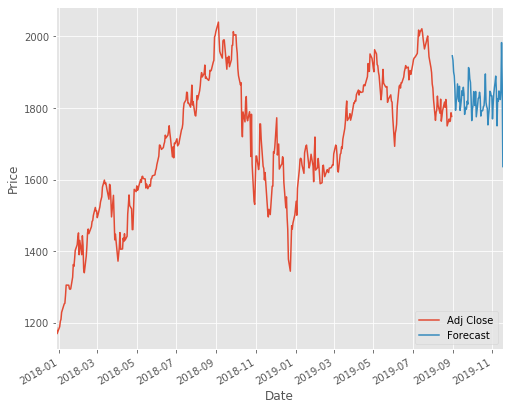

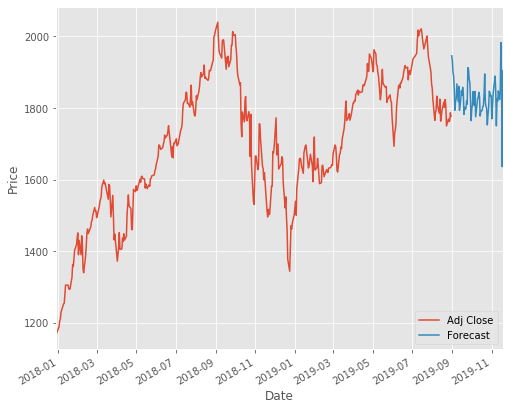

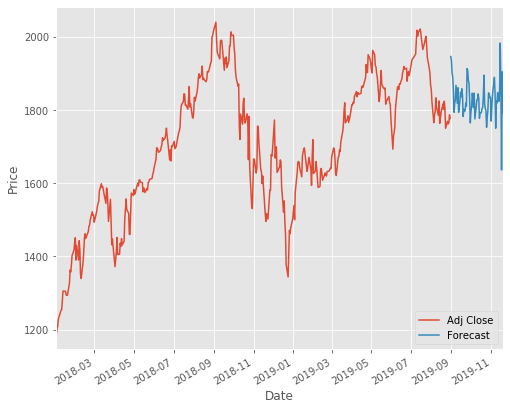

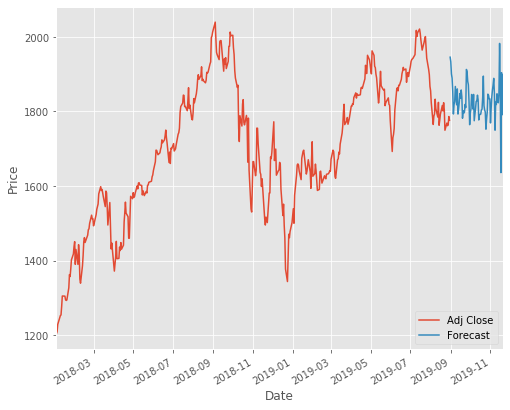

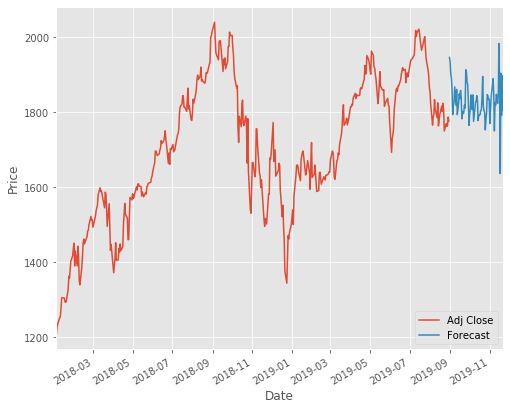

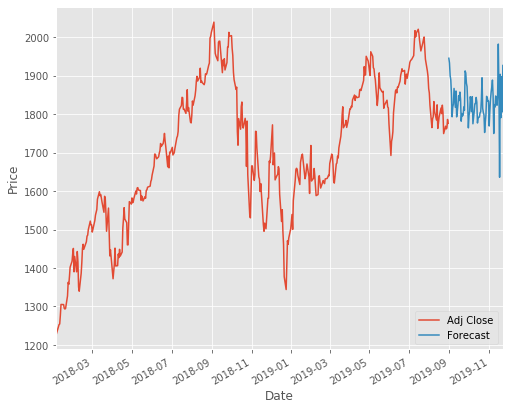

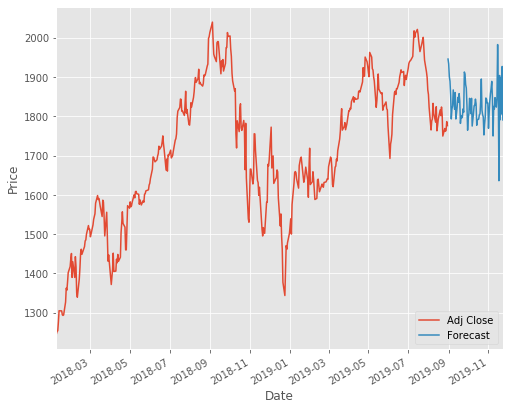

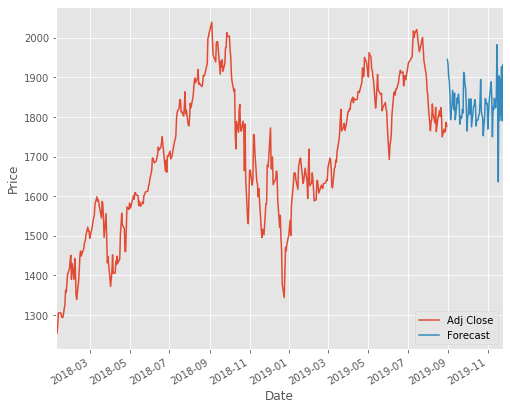

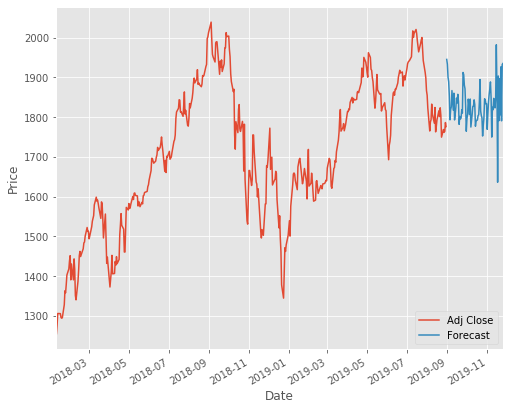

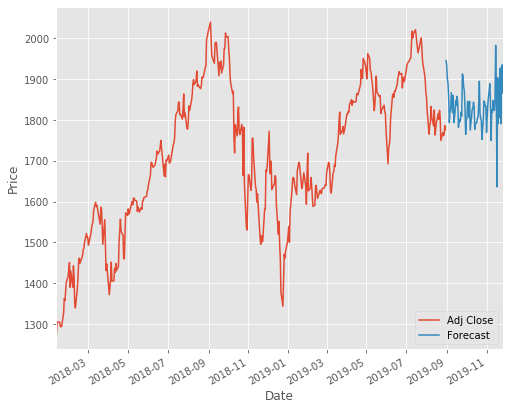

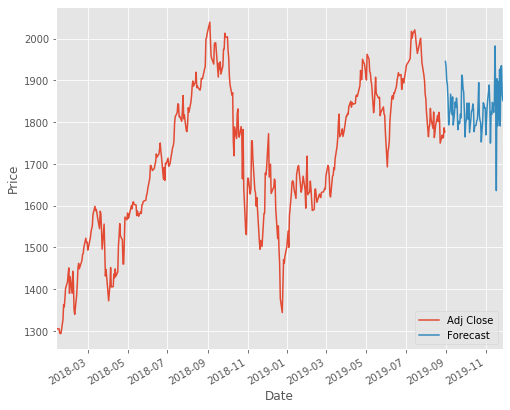

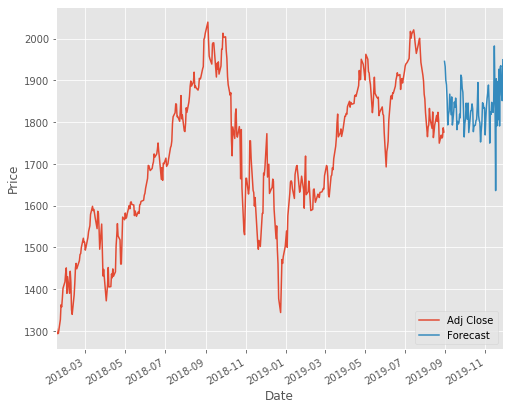

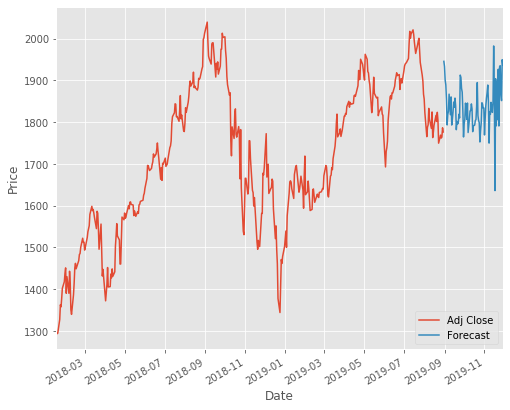

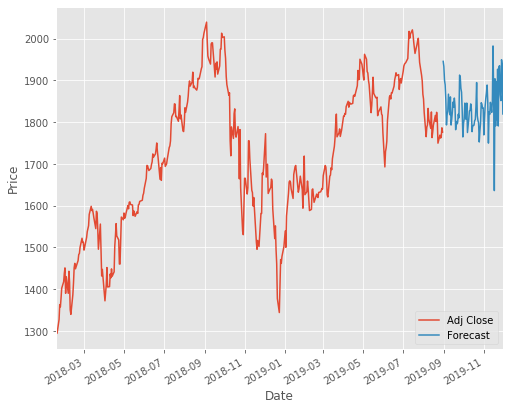

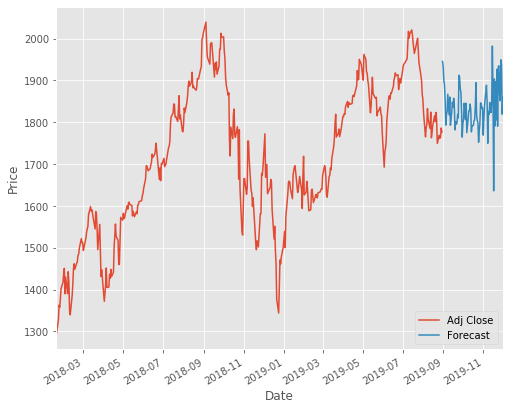

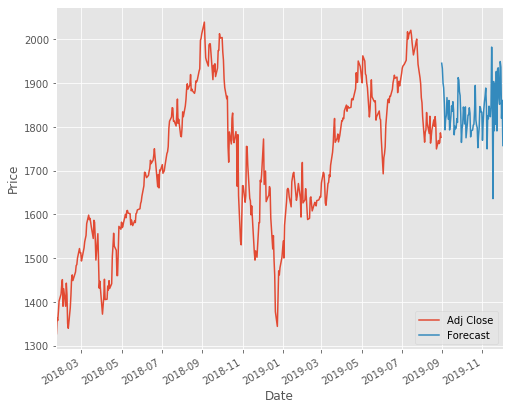

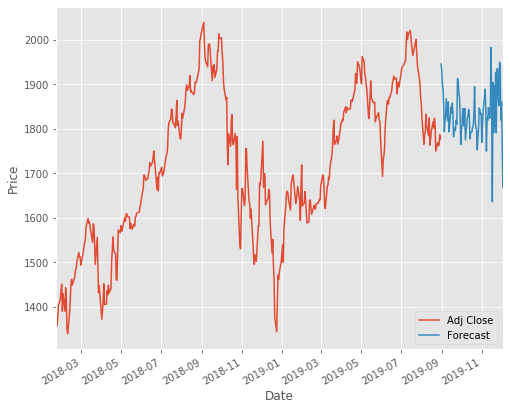

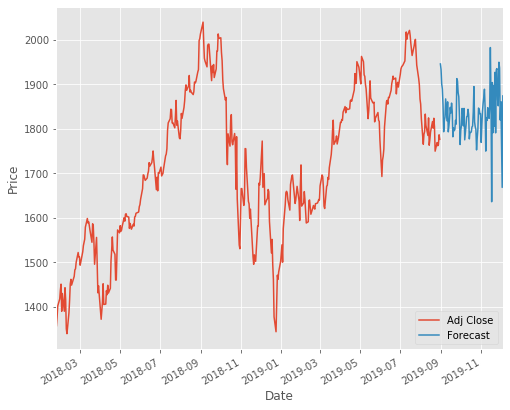

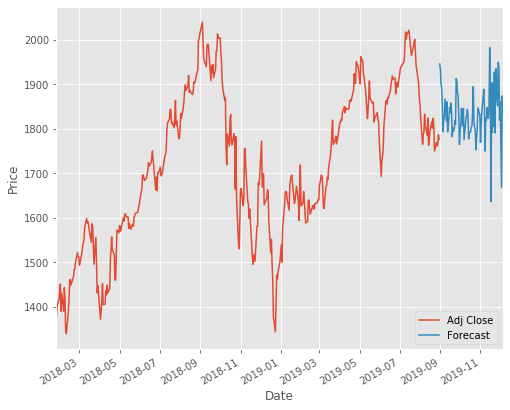

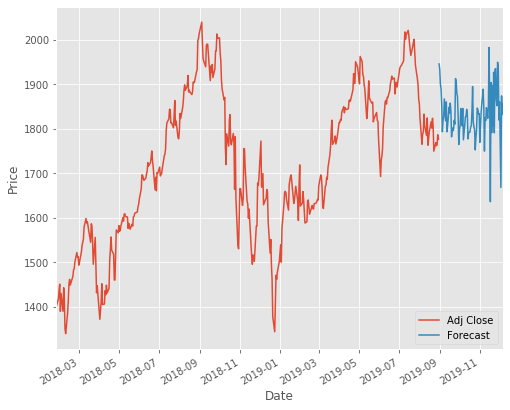

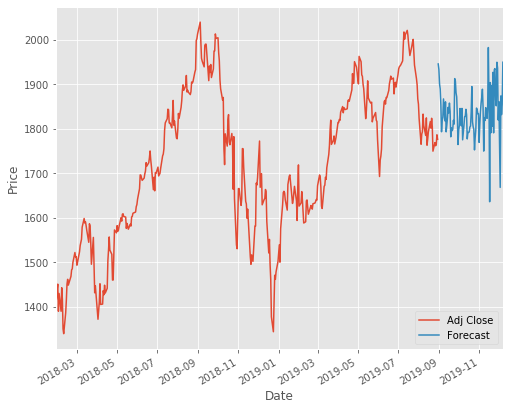

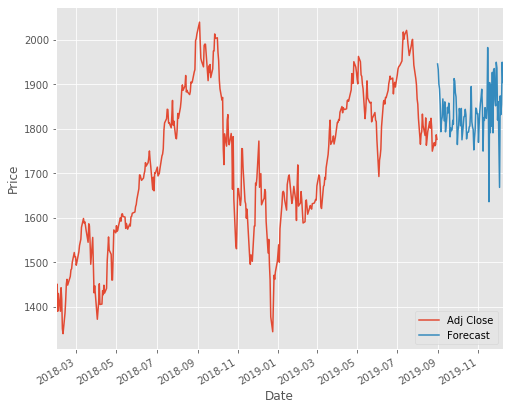

In [20]:
for i in forecast_set_knn: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()